In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from matplotlib.patches import Polygon


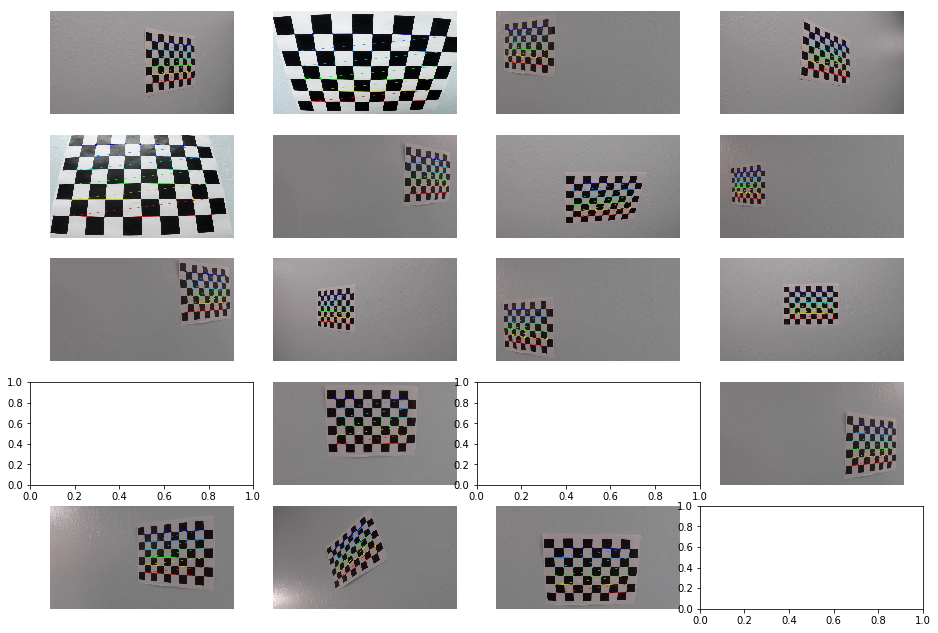

In [2]:
#TODO
#average previous for fail safe in poor lighting/other conditions
#catch for similarity in left & right lines / balance the more radical using most like previous
#simple catch for bad lines based on avg road width (line to line)
#smooth the line base at bottom of video

images = glob.glob('./camera_cal/calibration*.jpg')
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objpoints = []
imgpoints = []
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
fig, axis = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axis = axis.ravel()
i = 0
for img_name in images:
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        img = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        axis[i].axis('off')
        axis[i].imshow(img)
    i+=1

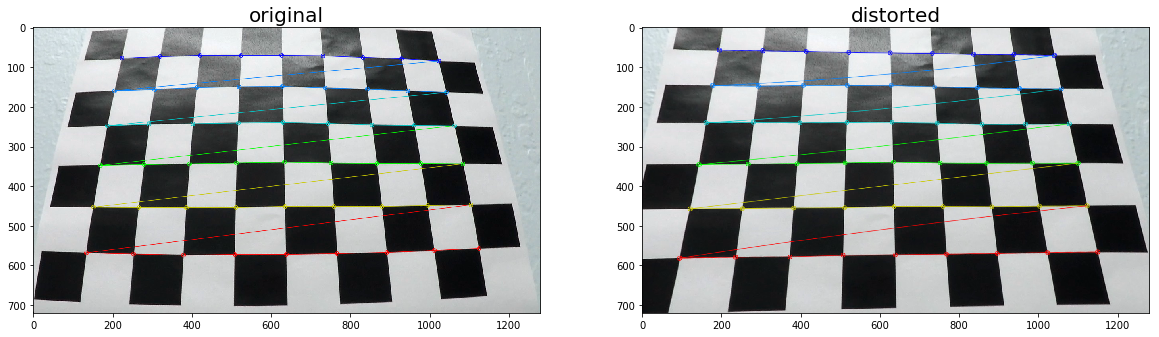

In [3]:
img = cv2.imread('./camera_cal/calibration3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

def plot_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=20)
    ax1.imshow(img_1, cmap='gray')
    ax2.set_title(title_2, fontsize=20)
    ax2.imshow(img_2, cmap='gray')
    
plot_images(img, "original", dst, "distorted")

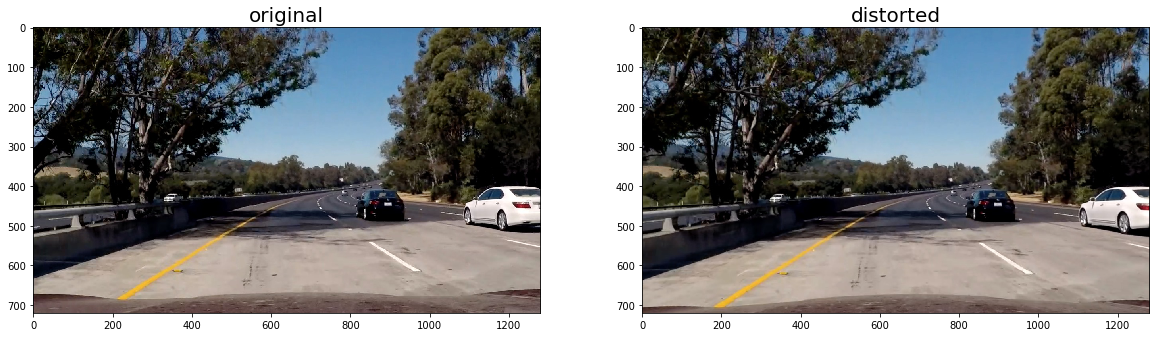

In [4]:
def load_images(path='./test_images/*.jpg'):
    images = []
    for file in glob.glob(path):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def undistort(img, mtx=mtx, dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

images = load_images()
img = images[3]
img = undistort(img)


plot_images(images[3], "original", img, "distorted")

In [5]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def col_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output



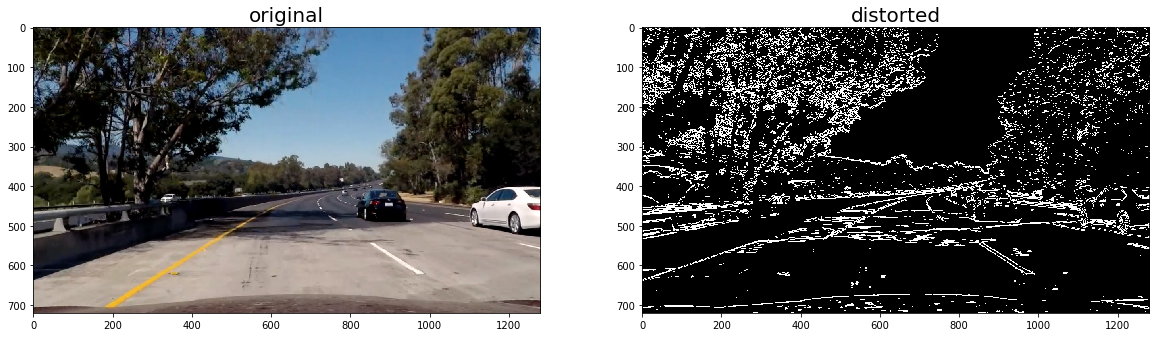

In [6]:
grad_x = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(20, 100))
grad_y = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=15, thresh=(70, 100))
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
col_binary = col_thresh(img, thresh=(170, 255))

plot_images(img, "original", grad_y, "distorted")

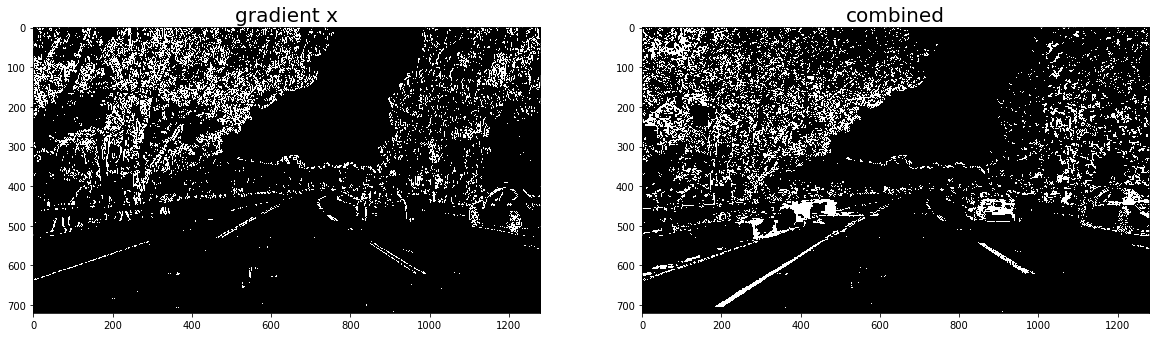

In [7]:
def comb_thresh(grad_x, grad_y, mag_binary, dir_binary, col_binary):
    combo_img = np.zeros_like(dir_binary)
    combo_img[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    return combo_img

combined = comb_thresh(grad_x, grad_y, mag_binary, dir_binary, col_binary)
plot_images(grad_x, "gradient x", combined, "combined")

In [8]:
def warp_perspective(img, src=None, dst=None):
    img_size = (img.shape[1], img.shape[0])
    if src is None:
        src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst is None:
        dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right 
    m = cv2.getPerspectiveTransform(src, dst)
    minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    return warped, m, minv

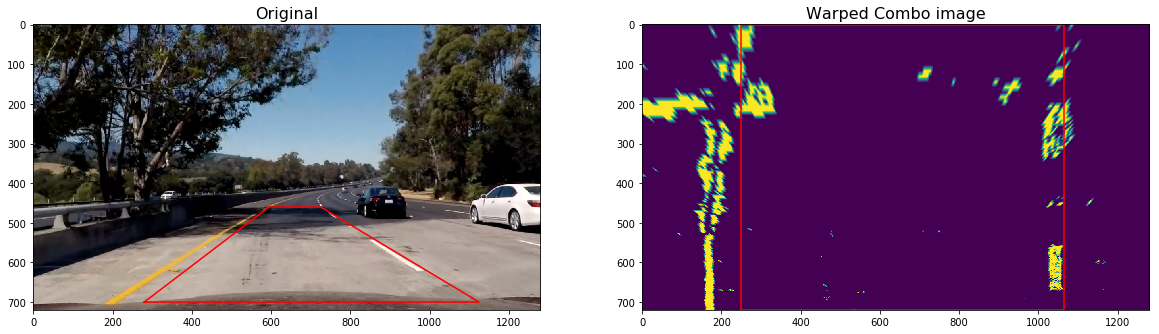

In [9]:
# Run the function
src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   

warped_img, _ , minv  = warp_perspective(combined, src, dst)

# Visualize undirstorsion
# Notice 'img' was undistorted at the beginning
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original', fontsize=16)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(img)

ax2.set_title('Warped Combo image', fontsize=16)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

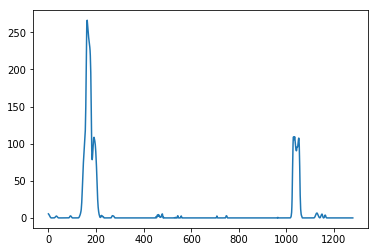

In [10]:
def genHistogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)

histo = genHistogram(warped_img)
plt.plot(histo)


Left poly is 414.8268173508077 and right poly is 1056.8103592098241
Car offset is 0.11962371980256217


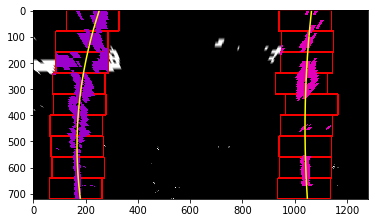

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(10,0,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(10,0,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [100, 0, 53]
    out_img[righty, rightx] = [30, 0, 70]
    #plt.imshow(out_img)

    #print("The curvature for left is {} and right is {}".format(curves[0], curves[1]))

    return out_img, left_fitx, right_fitx, ploty


def car_offset(left_fitx, right_fitx, img_shape, xm_per_pix=3.7/800):
    mid_x = img_shape[1]//2
    car_pos = (left_fitx[-1] + right_fitx[-1])/2
    offsetx = (mid_x - car_pos) * xm_per_pix
    return offsetx


def measure_curvature(left_fitx, right_fitx, ploty, xm_per_pix=3.7/800, ym_per_pix = 25/720):
        leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
        rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
        
        # Fit a second order polynomial
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 25/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/800 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        y_eval = np.max(ploty)
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        # Now our radius of curvature is in meters
        return (left_curverad, right_curverad)

out_img, left_points, right_points, ploty = fit_polynomial(warped_img)

    # Plots the left and right polynomials on the lane lines
plt.plot(left_points, ploty, color='yellow')
plt.plot(right_points, ploty, color='yellow')
plt.imshow(out_img)

curve = measure_curvature(left_points, right_points, ploty)
vehicle_offset = car_offset(left_points, right_points, img_shape=img.shape, xm_per_pix=3.7/800)
print("Left poly is {} and right poly is {}".format(curve[0], curve[1]))
print("Car offset is {}".format(vehicle_offset))

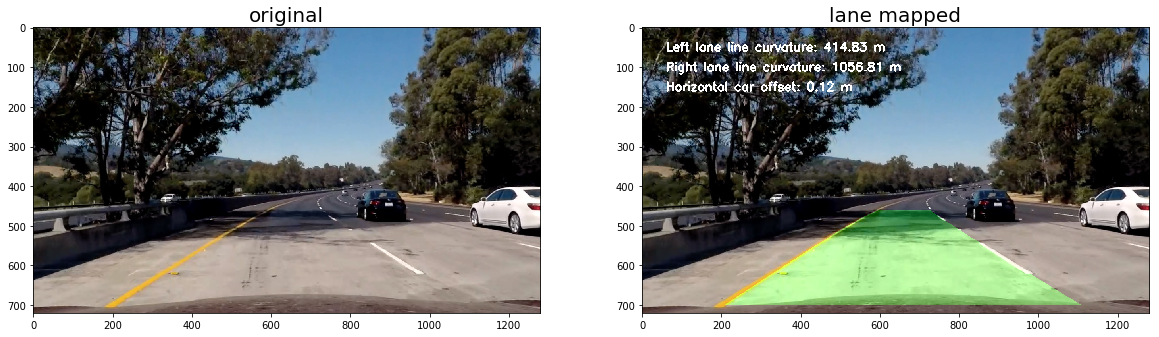

In [12]:
def draw_lane(img, warped_img, left_points, right_points, ploty, minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points
    right_fitx = right_points
    #ploty = left_points[1]
    

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (minv)
    newwarp = cv2.warpPerspective(color_warp, minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

lane_mapped = draw_lane(img, combined, left_points, right_points, ploty, minv)

def add_metrics(img, left_points, right_points, ploty):    
    curvature = measure_curvature(left_points, right_points, ploty)
    vehicle_offset = car_offset(left_points, right_points, img_shape=img.shape, xm_per_pix=3.7/800)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 3)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 3)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(vehicle_offset), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 3)
    
    return out_img

lane_mapped = add_metrics(lane_mapped, left_points, right_points, ploty)

plot_images(img, "original", lane_mapped, "lane mapped")

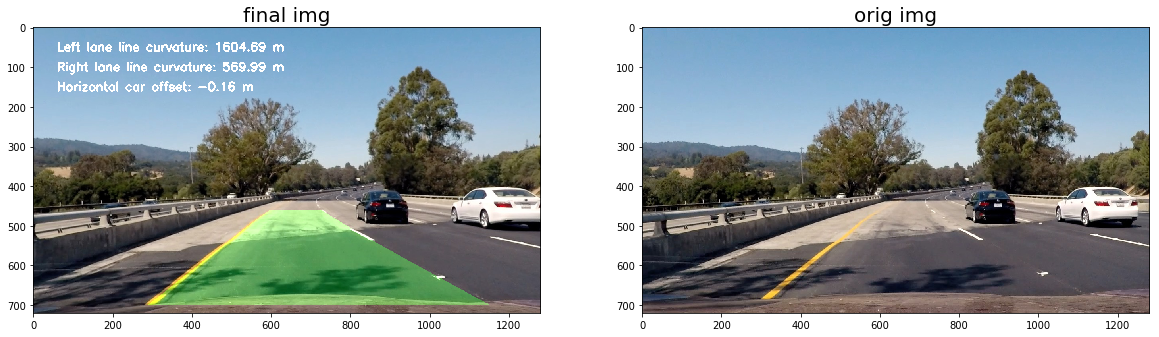

In [13]:
def runPipeline(base_img):
    base_img = undistort(base_img)
    grad_x = abs_sobel_thresh(base_img, orient='x', sobel_kernel=15, thresh=(20, 100))
    grad_y = abs_sobel_thresh(base_img, orient='y', sobel_kernel=15, thresh=(20, 100))
    mag_binary = mag_thresh(base_img, sobel_kernel=15, thresh=(70, 100))
    dir_binary = dir_thresh(base_img, sobel_kernel=15, thresh=(0.7, 1.3))
    col_binary = col_thresh(base_img, thresh=(170, 255))
    combined = comb_thresh(grad_x, grad_y, mag_binary, dir_binary, col_binary)
   
    src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

    dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right  
    
    warped_img, _ , minv  = warp_perspective(combined, src, dst)
    histo = genHistogram(warped_img)
    out_img, left_points, right_points, ploty = fit_polynomial(warped_img)
    curve = measure_curvature(left_points, right_points, ploty)
    vehicle_offset = car_offset(left_points, right_points, img_shape=img.shape, xm_per_pix=3.7/800)
    lane_mapped = draw_lane(base_img, combined, left_points, right_points, ploty, minv)
    lane_mapped = add_metrics(lane_mapped, left_points, right_points, ploty)
    
    return lane_mapped


numb = 0
for test_img in images:
    final_img = runPipeline(test_img)
    filename = 'output_images/test%s.jpg' % (numb)
    cv2.imwrite(filename, final_img)
    numb += 1
    
plot_images(final_img, "final img", test_img, "orig img")

In [14]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

proj_output = 'output_project_video.mp4'
n_clip = VideoFileClip("project_video.mp4")#.subclip(0,5)
f_clip = n_clip.fl_image(runPipeline)
%time f_clip.write_videofile(proj_output, audio=False)


[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [08:04<00:00,  2.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 5min 40s, sys: 13.1 s, total: 5min 53s
Wall time: 8min 7s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_output))